In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import numpy as np

from lime import lime_image
from skimage.segmentation import mark_boundaries

d:\X_AI_project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Pretrained model
import torchvision.models as models
model = models.resnext50_32x4d()
model.fc = nn.Linear(model.fc.in_features, 15)
model.load_state_dict(torch.load("trained_model.pth",map_location=torch.device('cpu'),weights_only=True))

<All keys matched successfully>

In [3]:
# data preprocessing
def preprocess(img):
    preprocess_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
        )
    ])
    processed = preprocess_transforms(img)
    return processed

preprocess(Image.open("eval_data/BAS/0.jpg"))

tensor([[[1.9064, 1.8722, 1.7865,  ..., 1.9920, 1.9749, 1.9407],
         [2.0263, 1.9920, 1.9407,  ..., 1.9920, 1.9749, 1.9407],
         [2.1290, 2.0948, 2.0605,  ..., 1.9749, 1.9578, 1.9407],
         ...,
         [2.0948, 2.1119, 2.0777,  ..., 1.3927, 1.3927, 1.3927],
         [2.1290, 2.1633, 2.1462,  ..., 1.4098, 1.4098, 1.4098],
         [2.1804, 2.2147, 2.1975,  ..., 1.3755, 1.3755, 1.3755]],

        [[1.9559, 1.9209, 1.8158,  ..., 2.1310, 2.1134, 2.0784],
         [2.0784, 2.0434, 1.9909,  ..., 2.1310, 2.1134, 2.0784],
         [2.1835, 2.1485, 2.1134,  ..., 2.1134, 2.0959, 2.0784],
         ...,
         [2.1660, 2.1835, 2.1485,  ..., 0.8704, 0.8704, 0.8704],
         [2.2360, 2.2710, 2.2185,  ..., 0.8704, 0.8704, 0.8704],
         [2.3060, 2.3235, 2.2710,  ..., 0.8354, 0.8354, 0.8354]],

        [[2.3088, 2.2740, 2.2217,  ..., 2.3611, 2.3437, 2.3088],
         [2.4308, 2.3960, 2.3437,  ..., 2.3611, 2.3437, 2.3088],
         [2.5180, 2.4831, 2.4483,  ..., 2.3437, 2.3263, 2.

In [4]:
def predict_img(images):
    img_batch = torch.stack([preprocess(Image.fromarray((img*255).astype(np.uint8))) for img in images])
    with torch.no_grad():
        pred = model(img_batch)
        prob = torch.nn.functional.softmax(pred,dim=1)
    return prob.numpy()

In [23]:
from lime import lime_image
from skimage import segmentation

# Classes 3,4,6,7,9 and 13 will be excluded because they have less than 10 samples in the test set.

image_explainer = lime_image.LimeImageExplainer()

base_img_path = "eval_data/EOS/1.jpg"
img = Image.open(base_img_path)

explanation = image_explainer.explain_instance(
    np.array(img),
    predict_img,
    batch_size = 10,
    hide_color=((0,0,0)),
    num_features=16000,
    random_seed=0
)


100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


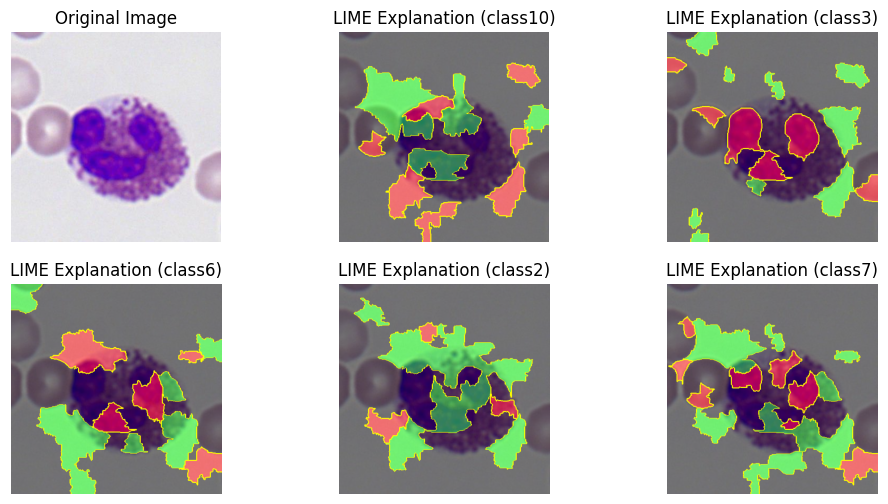

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3, figsize=(12,6))

axes[0][0].imshow(Image.open(base_img_path))
axes[0][0].set_title("Original Image")
axes[0][0].axis("off")

for i in range(0,5,1):
    # Pick the top predicted class
    top_label = explanation.top_labels[i]

    # Get image & mask for visualization
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=False,
        num_features=20,
        hide_rest=True
    )

    overlay = np.zeros((*mask.shape,3), dtype=np.float32)
    overlay[mask == 1] = [0,1,0]
    overlay[mask == -1] = [1,0,0]

    combined = 0.5 * np.array(Image.open(base_img_path)) / 255.0 + 0.5* overlay
    i = i+1
    axes[int(i/3)][i%3].imshow(mark_boundaries(combined, mask))
    axes[int(i/3)][i%3].set_title(f"LIME Explanation (class{top_label})")
    axes[int(i/3)][i%3].axis("off")



#plt.imshow(mark_boundaries(combined, mask))
#plt.axis('off')
#plt.show()


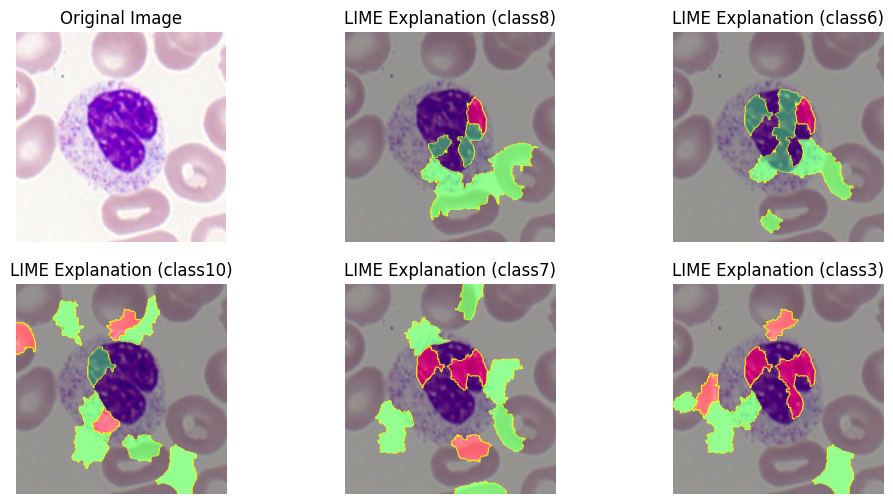